<a href="https://colab.research.google.com/github/rodespdi/PDA2526/blob/main/Deformaciones_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔬 Explicación Detallada del Código: Deformaciones 3D

Este *notebook* demuestra cómo crear una figura 3D compleja y aplicarle cuatro tipos diferentes de deformaciones matemáticas (Torsión, Afilado, Flexión y Cizallamiento). El objetivo es visualizar cómo cambian las coordenadas de un objeto basándose en funciones de su posición, particularmente en el eje Z.

-----

## 1\. Importación de Bibliotecas

Primero, importamos las herramientas necesarias:

  * **`numpy` (como `np`)**: La biblioteca fundamental para computación numérica en Python. La usamos para manejar nuestros arreglos de coordenadas (vectores y matrices) y para operaciones matemáticas (como `cos`, `sin`, `exp`).
  * **`matplotlib.pyplot` (como `plt`)**: La biblioteca principal para crear visualizaciones estáticas y animadas. La usaremos para crear nuestras ventanas de gráficos y subplots.
  * **`skimage.measure`**: Un módulo de la biblioteca `scikit-image`. Específicamente, importamos la función `marching_cubes`, que es la herramienta clave para crear una superficie 3D (una "malla") a partir de un volumen de datos.
  * **`mpl_toolkits.mplot3d`**: Aunque no lo llamemos directamente, importar `Axes3D` es necesario para registrar la capacidad de hacer gráficos 3D (`projection='3d'`) con Matplotlib.

<!-- end list -->

```python
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from mpl_toolkits.mplot3d import Axes3D
```

-----

## 2\. Creación de la Figura Original (El "Molde")

Antes de deformar algo, necesitamos crearlo. Lo hacemos en varios pasos:

### Paso 1: Definir el Espacio (Rejilla)

Creamos una "rejilla" o "cuadrícula" 3D que define el universo en el que existirá nuestra figura.

  * **`np.arange(...)`**: Define los puntos a lo largo de cada eje (X, Y, Z). Por ejemplo, de -2 a +2 con pasos de 0.2.
  * **`np.meshgrid(...)`**: Toma estos tres rangos y crea tres matrices 3D (`X`, `Y`, `Z`). Cada matriz contiene la coordenada X, Y, o Z de *cada* punto en la rejilla. `indexing='ij'` se usa para que el orden de los ejes coincida con el de MATLAB, lo que facilita la transición.

### Paso 2: Definir la Forma (Volumen)

Creamos una matriz booleana (Verdadero/Falso) llamada `V_shape` que tiene la misma dimensión que nuestra rejilla.

  * La fórmula lógica `((np.abs(X) <= 1.5) & (np.abs(Y) <= 0.5)) | ...` define nuestra forma.
  * `|` significa "O" (OR) y `&` significa "Y" (AND).
  * La lógica describe una forma de cruz en el plano XY: un rectángulo ancho y corto O un rectángulo alto y estrecho.
  * Como esta condición no depende de `Z`, esta cruz se "extruye" a lo largo de todo el eje Z, creando un prisma con forma de cruz.

### Paso 3: Extraer la Superficie (La "Piel")

Ahora mismo, `V_shape` es un volumen sólido. Para dibujarlo, solo necesitamos su superficie exterior.

  * **`measure.marching_cubes(V_shape, level=0.5, ...)`**: Esta es la función mágica. Analiza el volumen `V_shape` (donde `True`=1 y `False`=0) y encuentra la superficie donde el valor pasa de 0 a 1 (el "borde"). `level=0.5` define ese borde.
  * Nos devuelve:
      * **`verts` (Vértices)**: Una larga lista de coordenadas `[x, y, z]` de todos los puntos que componen la superficie.
      * **`faces` (Caras)**: Una lista que define cómo se conectan los vértices para formar triángulos, que es lo que la tarjeta gráfica dibuja.

### Paso 4: Ajustar Coordenadas y Extraer Ejes

`marching_cubes` devuelve los vértices en coordenadas de "índice" (ej., 0, 1, 2...). Necesitamos moverlos a nuestras coordenadas del "mundo real" (ej., -2, -1.8, ...).

  * **`V_orig = verts + [x_range[0], y_range[0], z_range[0]]`**: Simplemente sumamos las coordenadas de inicio de nuestros rangos a todos los vértices.
  * **`x, y, z = V_orig[:, 0], ...`**: Para facilitar los cálculos, separamos las columnas de `V_orig` en variables `x`, `y`, `z` individuales.

-----

## 3\. Aplicación de las Deformaciones

Aquí es donde ocurre la transformación. Para cada deformación, seguimos el mismo patrón:

1.  Definir una ecuación matemática que calcule nuevas coordenadas (`x_new`, `y_new`, `z_new`) basadas en las antiguas (`x`, `y`, `z`).
2.  La clave es que la deformación **depende de `z`**.
3.  Creamos una nueva matriz de vértices (`V_twisted`, `V_tapered`, etc.) con las nuevas coordenadas.

📐 Deformación 1: Torsión (Twist)

  * **Concepto 💡:** Girar la figura sobre sí misma, como un tornillo. El ángulo de giro depende de la altura (Z).
  * **Ecuación Clave:** `theta = twist_factor * z`.
      * En el centro (`z=0`), `theta` es 0 (sin rotación).
      * En `z>0`, gira en una dirección. En `z<0`, gira en la opuesta.
  * **Implementación:** Aplicamos la **matriz de rotación 2D** estándar a cada punto `(x, y)` usando su ángulo `theta` individual:
      * `x_new = x * cos(theta) - y * sin(theta)`
      * `y_new = x * sin(theta) + y * cos(theta)`

📐 Deformación 2: Afilado (Tapering)

  * **Concepto 💡:** Encoger la figura en los planos XY a medida que se aleja del centro. Como la punta de un lápiz.
  * **Ecuación Clave:** `scale = np.exp(-taper_factor * np.abs(z / max_z))`
      * Usamos `np.abs(z)` para que se encoja simétricamente en ambos extremos (+Z y -Z).
      * Usamos una **función exponencial** para un encogimiento suave. Cuando `z=0`, `scale=exp(0)=1` (sin cambio). A medida que `|z|` aumenta, `scale` se acerca a 0.
  * **Implementación:** Simplemente escalamos `x` e `y`:
      * `x_new = x * scale`
      * `y_new = y * scale`

📐 Deformación 3: Flexión (Bending)

  * **Concepto 💡:** Doblar la figura, como una viga bajo carga. El desplazamiento es nulo en el centro y máximo en los extremos.
  * **Ecuación Clave:** `x_bent = x + bend_factor * (z**2)`
      * Usamos una **función cuadrática (parábola)** `z**2`.
      * En `z=0`, el desplazamiento es 0.
      * En `z=10` y `z=-10`, `z**2` es 100 en ambos casos. Esto significa que ambos extremos se desplazan en la *misma* dirección (`+X`), creando la forma de "C" o "U".
  * **Implementación:** Es un simple **desplazamiento** (traslación) en X.

 📐 Deformación 4: Cizallamiento (Shear)

  * **Concepto 💡:** Inclinar la figura, como una baraja de cartas que empujas. Las capas se deslizan unas sobre otras.
  * **Ecuación Clave:** `x_shear = x + shear_factor * z`
      * Usamos una **función lineal** de `z`.
      * En `z=0`, el desplazamiento es 0.
      * En `z=10` (extremo positivo), se desplaza en `+X`.
      * En `z=-10` (extremo negativo), se desplaza en `-X`.
  * **Implementación:** Esto crea la forma inclinada "S", a diferencia de la forma "C" de la flexión.

-----

## 4\. Visualización (Plotting)

Finalmente, dibujamos los resultados. El código de ploteo es repetitivo para cada ejemplo:

1.  **`fig = plt.figure(...)`**: Crea una nueva ventana para el gráfico.
2.  **`ax = fig.add_subplot(1, 2, 1, projection='3d')`**: Añade un "subplot" (un gráfico dentro de la ventana). `(1, 2, 1)` significa "1 fila, 2 columnas, este es el 1er gráfico". `projection='3d'` activa el modo 3D.
3.  **`ax.plot_trisurf(V[:, 0], V[:, 1], V[:, 2], triangles=faces, ...)`**: Esta es la función principal de dibujo. Dibuja una superficie de triángulos. Le pasamos las coordenadas de los vértices (desempaquetadas) y la lista `faces` que le dice cómo conectarlos.
4.  **`ax.set_box_aspect([1,1,1])`**: ¡Muy importante\! Es el equivalente de `axis equal` en MATLAB. Asegura que las escalas de los ejes X, Y y Z sean idénticas, para que la figura no se vea estirada o aplastada.
5.  **`ax.set_xlim(...)`**: Fijamos los límites de los ejes para que la figura original y la deformada se muestren en la misma escala, permitiendo una comparación justa.
6.  **`plt.show()`**: Muestra todas las ventanas de figuras que hemos creado.

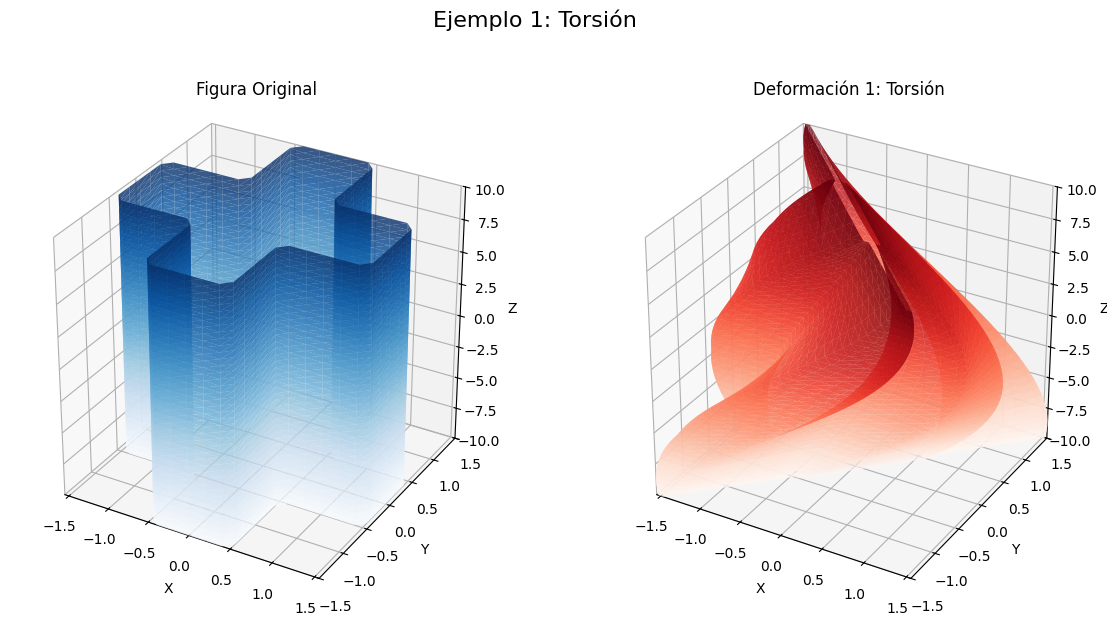

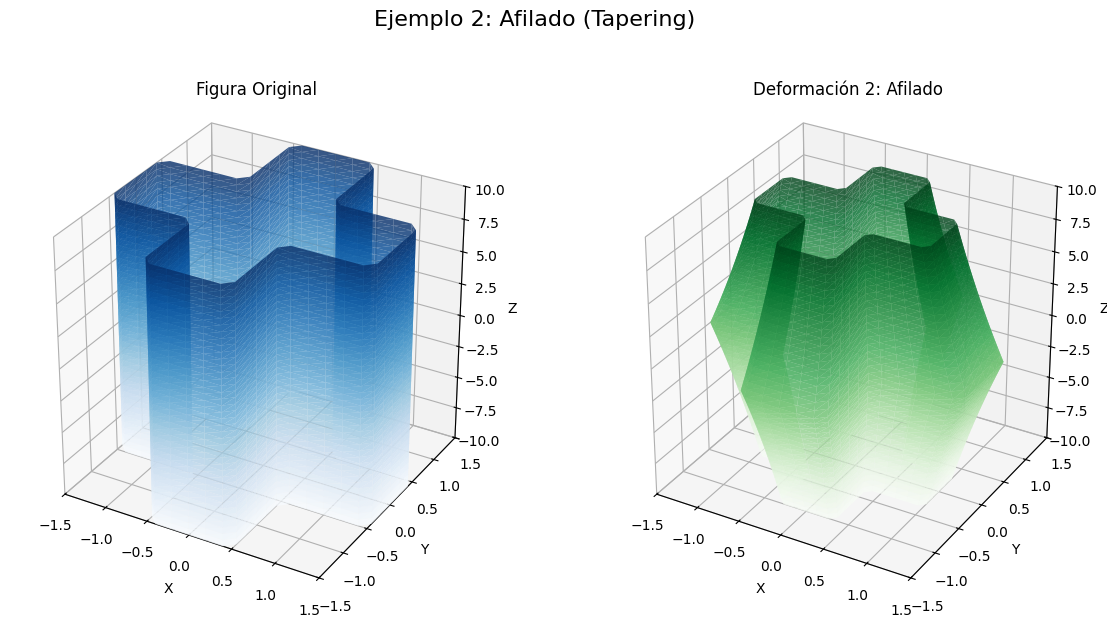

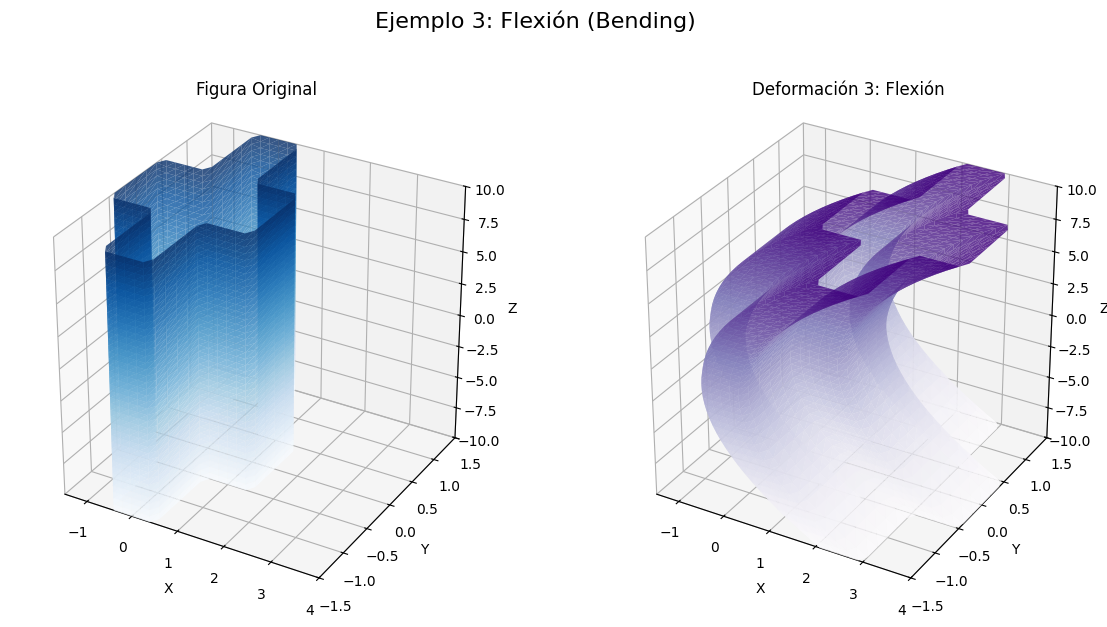

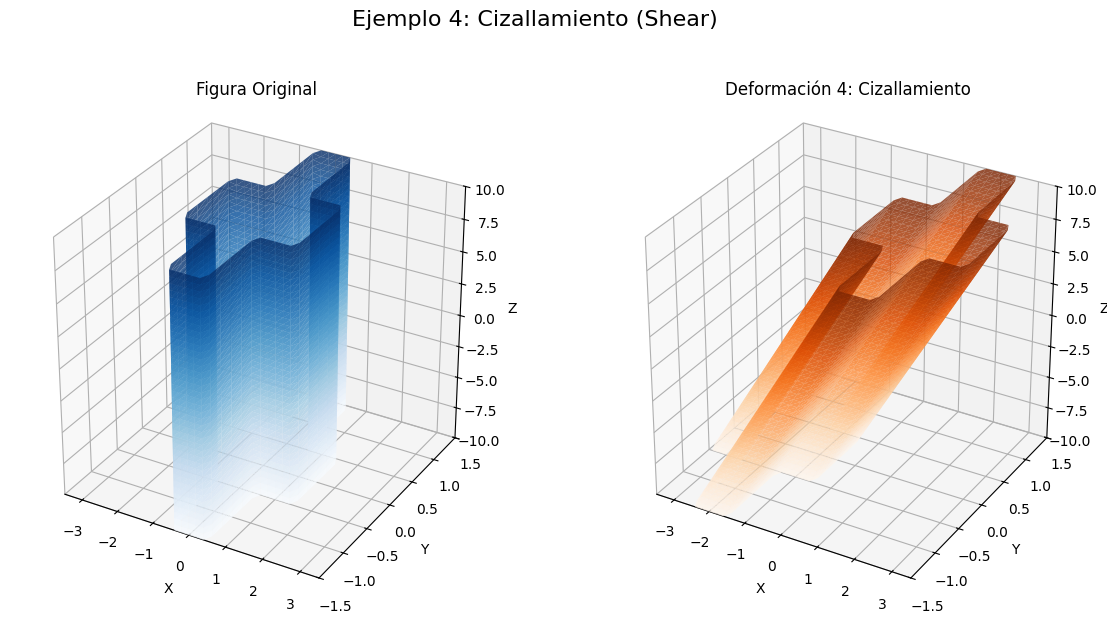

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from mpl_toolkits.mplot3d import Axes3D # Necesario para proyección 3D

# --- Configuración Inicial: Definir la Figura Original ---

# 1. Definir los rangos de la rejilla
step_xy = 0.2
step_z = 0.5
x_range = np.arange(-2, 2 + step_xy, step_xy)
y_range = np.arange(-2, 2 + step_xy, step_xy)
z_range = np.arange(-10, 10 + step_z, step_z)

# 2. Crear una rejilla 3D (meshgrid)
X, Y, Z = np.meshgrid(x_range, y_range, z_range, indexing='ij')

# 3. Definir la forma (una cruz extruida en Z)
V_shape = ((np.abs(X) <= 1.5) & (np.abs(Y) <= 0.5)) | \
          ((np.abs(X) <= 0.5) & (np.abs(Y) <= 1.5))

# 4. Obtener las caras (F) y vértices (V_orig) de la superficie
verts, faces, _, _ = measure.marching_cubes(
    V_shape,
    level=0.5,
    spacing=(step_xy, step_xy, step_z)
)

# 5. Ajustar los vértices a las coordenadas del mundo real
V_orig = verts + [x_range[0], y_range[0], z_range[0]]

# Extraer coordenadas originales (se usarán en todos los ejemplos)
x = V_orig[:, 0]
y = V_orig[:, 1]
z = V_orig[:, 2]

# --- EJEMPLO 1: DEFORMACIÓN POR TORSIÓN ---

twist_factor = 0.15
theta = twist_factor * z
x_twisted = x * np.cos(theta) - y * np.sin(theta)
y_twisted = x * np.sin(theta) + y * np.cos(theta)
V_twisted = np.column_stack([x_twisted, y, z_twisted]) # Z no cambia (z_twisted = z)

fig1 = plt.figure(figsize=(14, 7))
fig1.suptitle('Ejemplo 1: Torsión', fontsize=16)
all_verts_twist = np.vstack([V_orig, V_twisted])
min_vals, max_vals = all_verts_twist.min(axis=0), all_verts_twist.max(axis=0)

ax1 = fig1.add_subplot(1, 2, 1, projection='3d')
ax1.plot_trisurf(V_orig[:, 0], V_orig[:, 1], V_orig[:, 2], triangles=faces, cmap='Blues', alpha=0.8)
ax1.set_title('Figura Original')
ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z')
ax1.set_xlim(min_vals[0], max_vals[0]); ax1.set_ylim(min_vals[1], max_vals[1]); ax1.set_zlim(min_vals[2], max_vals[2])
ax1.set_box_aspect([1,1,1])

ax2 = fig1.add_subplot(1, 2, 2, projection='3d')
ax2.plot_trisurf(V_twisted[:, 0], V_twisted[:, 1], V_twisted[:, 2], triangles=faces, cmap='Reds', alpha=0.8)
ax2.set_title('Deformación 1: Torsión')
ax2.set_xlabel('X'); ax2.set_ylabel('Y'); ax2.set_zlabel('Z')
ax2.set_xlim(min_vals[0], max_vals[0]); ax2.set_ylim(min_vals[1], max_vals[1]); ax2.set_zlim(min_vals[2], max_vals[2])
ax2.set_box_aspect([1,1,1])

# --- EJEMPLO 2: DEFORMACIÓN POR AFILADO (TAPERING) ---

taper_factor = 0.4
max_z = np.max(np.abs(z))
if max_z == 0: max_z = 1
scale = np.exp(-taper_factor * np.abs(z / max_z))
x_tapered = x * scale
y_tapered = y * scale
V_tapered = np.column_stack([x_tapered, y_tapered, z]) # Z no cambia

fig2 = plt.figure(figsize=(14, 7))
fig2.suptitle('Ejemplo 2: Afilado (Tapering)', fontsize=16)
all_verts_taper = np.vstack([V_orig, V_tapered])
min_vals, max_vals = all_verts_taper.min(axis=0), all_verts_taper.max(axis=0)

ax3 = fig2.add_subplot(1, 2, 1, projection='3d')
ax3.plot_trisurf(V_orig[:, 0], V_orig[:, 1], V_orig[:, 2], triangles=faces, cmap='Blues', alpha=0.8)
ax3.set_title('Figura Original')
ax3.set_xlabel('X'); ax3.set_ylabel('Y'); ax3.set_zlabel('Z')
ax3.set_xlim(min_vals[0], max_vals[0]); ax3.set_ylim(min_vals[1], max_vals[1]); ax3.set_zlim(min_vals[2], max_vals[2])
ax3.set_box_aspect([1,1,1])

ax4 = fig2.add_subplot(1, 2, 2, projection='3d')
ax4.plot_trisurf(V_tapered[:, 0], V_tapered[:, 1], V_tapered[:, 2], triangles=faces, cmap='Greens', alpha=0.8)
ax4.set_title('Deformación 2: Afilado')
ax4.set_xlabel('X'); ax4.set_ylabel('Y'); ax4.set_zlabel('Z')
ax4.set_xlim(min_vals[0], max_vals[0]); ax4.set_ylim(min_vals[1], max_vals[1]); ax4.set_zlim(min_vals[2], max_vals[2])
ax4.set_box_aspect([1,1,1])

# --- EJEMPLO 3: DEFORMACIÓN POR FLEXIÓN (BENDING) ---

bend_factor = 0.025
x_bent = x + bend_factor * (z**2)
V_bent = np.column_stack([x_bent, y, z]) # Y, Z no cambian

fig3 = plt.figure(figsize=(14, 7))
fig3.suptitle('Ejemplo 3: Flexión (Bending)', fontsize=16)
all_verts_bent = np.vstack([V_orig, V_bent])
min_vals, max_vals = all_verts_bent.min(axis=0), all_verts_bent.max(axis=0)
z_lims = [all_verts_bent[:, 2].min(), all_verts_bent[:, 2].max()]

ax5 = fig3.add_subplot(1, 2, 1, projection='3d')
ax5.plot_trisurf(V_orig[:, 0], V_orig[:, 1], V_orig[:, 2], triangles=faces, cmap='Blues', alpha=0.8)
ax5.set_title('Figura Original')
ax5.set_xlabel('X'); ax5.set_ylabel('Y'); ax5.set_zlabel('Z')
ax5.set_xlim(min_vals[0], max_vals[0]); ax5.set_ylim(min_vals[1], max_vals[1]); ax5.set_zlim(z_lims[0], z_lims[1])
ax5.set_box_aspect([1,1,1])

ax6 = fig3.add_subplot(1, 2, 2, projection='3d')
ax6.plot_trisurf(V_bent[:, 0], V_bent[:, 1], V_bent[:, 2], triangles=faces, cmap='Purples', alpha=0.8)
ax6.set_title('Deformación 3: Flexión')
ax6.set_xlabel('X'); ax6.set_ylabel('Y'); ax6.set_zlabel('Z')
ax6.set_xlim(min_vals[0], max_vals[0]); ax6.set_ylim(min_vals[1], max_vals[1]); ax6.set_zlim(z_lims[0], z_lims[1])
ax6.set_box_aspect([1,1,1])

# --- EJEMPLO 4: DEFORMACIÓN POR CIZALLAMIENTO (SHEAR) ---

# 1. Definir el factor de cizallamiento
shear_factor = 0.2

# 2. Calcular el desplazamiento en X
# Aplicamos un desplazamiento en X que es LINEAL con Z (x_new = x + k*z)
# Esto "inclina" la figura.
x_shear = x + shear_factor * z
y_shear = y  # Y no cambia
z_shear = z  # Z no cambia

# 3. Crear el nuevo conjunto de vértices
V_shear = np.column_stack([x_shear, y_shear, z_shear])

# 4. Dibujar la comparación (Cizallamiento)
fig4 = plt.figure(figsize=(14, 7))
fig4.suptitle('Ejemplo 4: Cizallamiento (Shear)', fontsize=16)

# Calcular límites compartidos
all_verts_shear = np.vstack([V_orig, V_shear])
min_vals, max_vals = all_verts_shear.min(axis=0), all_verts_shear.max(axis=0)
z_lims = [all_verts_shear[:, 2].min(), all_verts_shear[:, 2].max()]

# Subplot 1: Original
ax7 = fig4.add_subplot(1, 2, 1, projection='3d')
ax7.plot_trisurf(V_orig[:, 0], V_orig[:, 1], V_orig[:, 2], triangles=faces,
                 cmap='Blues', alpha=0.8)
ax7.set_title('Figura Original')
ax7.set_xlabel('X'); ax7.set_ylabel('Y'); ax7.set_zlabel('Z')
ax7.set_xlim(min_vals[0], max_vals[0]); ax7.set_ylim(min_vals[1], max_vals[1]); ax7.set_zlim(z_lims[0], z_lims[1])
ax7.set_box_aspect([1,1,1]) # 'axis equal'

# Subplot 2: Cizallamiento
ax8 = fig4.add_subplot(1, 2, 2, projection='3d')
ax8.plot_trisurf(V_shear[:, 0], V_shear[:, 1], V_shear[:, 2], triangles=faces,
                 cmap='Oranges', alpha=0.8)
ax8.set_title('Deformación 4: Cizallamiento')
ax8.set_xlabel('X'); ax8.set_ylabel('Y'); ax8.set_zlabel('Z')
ax8.set_xlim(min_vals[0], max_vals[0]); ax8.set_ylim(min_vals[1], max_vals[1]); ax8.set_zlim(z_lims[0], z_lims[1])
ax8.set_box_aspect([1,1,1]) # 'axis equal'


# Mostrar todas las figuras
plt.show()